Correlation between TSLA Return and Macroeconomics Data from FRED.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

[Text(0.5, 1.0, 'TSLA Monthly Returns')]

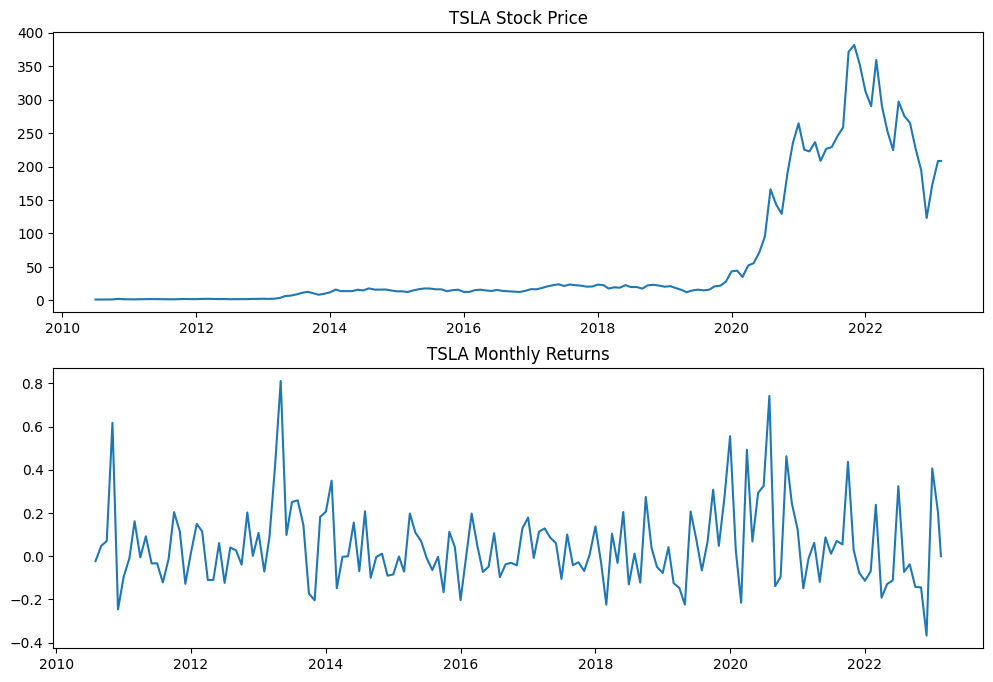

In [64]:

# Load TSLA stock price data
tsla_df = pd.read_csv('TSLAM.csv', index_col='Date', parse_dates=True)

tsla_df = tsla_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)                         

# Calculate daily returns and log returns
tsla_df['Return'] = tsla_df['Close'].pct_change()
tsla_df['Log Return'] = np.log(tsla_df['Close']) - np.log(tsla_df['Close'].shift(1))

# Plot TSLA's stock price and returns
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(tsla_df['Close'])
ax[0].set(title='TSLA Stock Price')
ax[1].plot(tsla_df['Return'])
ax[1].set(title='TSLA Monthly Returns')



[Text(0.5, 1.0, 'TSLA Mothly Returns with Rolling Mean and Standard Deviation')]

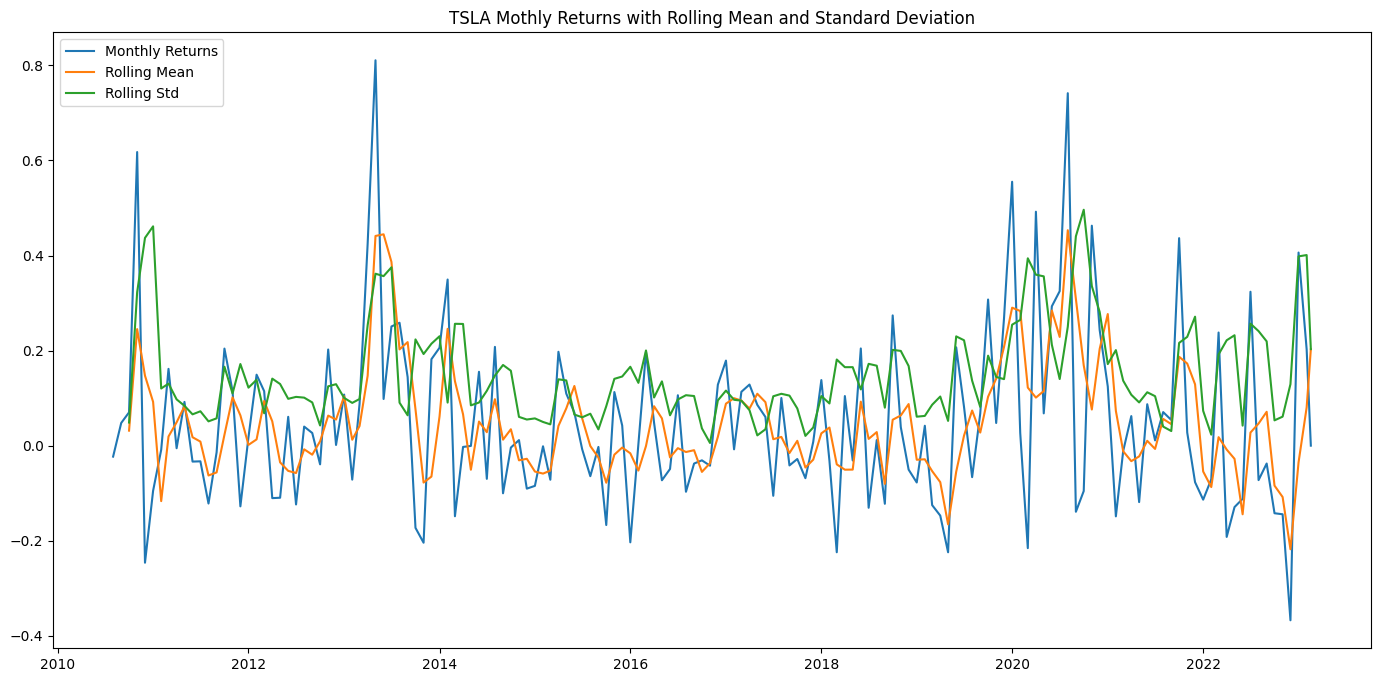

In [65]:

# Calculate rolling mean and standard deviation of returns
tsla_df['Rolling Mean'] = tsla_df['Return'].rolling(window=3).mean()
tsla_df['Rolling Std'] = tsla_df['Return'].rolling(window=3).std()

# Plot rolling mean and standard deviation of returns
fig, ax = plt.subplots(figsize=(17, 8))
ax.plot(tsla_df['Return'], label='Monthly Returns')
ax.plot(tsla_df['Rolling Mean'], label='Rolling Mean')
ax.plot(tsla_df['Rolling Std'], label='Rolling Std')
ax.legend(loc='upper left')
ax.set(title='TSLA Mothly Returns with Rolling Mean and Standard Deviation')

In [66]:

import datetime as dt
from fredapi import Fred

# API key for FRED
fred = Fred(api_key='0d053eafc9c4478bb521a57646ed999c')

# List of FRED series ids for the macroeconomic measures
macro_measures = ['GDP', 'CPALTT01USM657N', 'UNRATE', 'FEDFUNDS', 'PCE', 'GPDIC1', 'NETEXC']

# Start and end dates for the data
start_date = dt.datetime(2010, 6, 29)
end_date = dt.datetime.now()

# Download the data for each series and combine into a single dataframe
dataframes = []
for series_id in macro_measures:
    df = fred.get_series(series_id, start_date, end_date).to_frame(name=series_id)
    dataframes.append(df)
macro_df = pd.concat(dataframes, axis=1)


# Rename columns to more readable names
macro_df = macro_df.rename(columns={'GDP': 'Real GDP', 'CPALTT01USM657N': 'Inflation',
                                          'UNRATE': 'Unemployment Rate', 'FEDFUNDS': 'Interest Rate',
                                          'PCE': 'Consumer Spending', 'GPDIC1': 'Business Investment',
                                          'NETEXC': 'Trade Balance'})

# Drop any rows with missing values
macro_df = macro_df.dropna()

# Print the resulting dataframe
print(macro_df)

             Real GDP  Inflation  Unemployment Rate  Interest Rate  \
2010-07-01  15141.605   0.021104                9.4           0.18   
2010-10-01  15309.471   0.124520                9.4           0.19   
2011-01-01  15351.444   0.476323                9.1           0.17   
2011-04-01  15557.535   0.643943                9.1           0.10   
2011-07-01  15647.681   0.088605                9.0           0.07   
2011-10-01  15842.267  -0.206268                8.8           0.07   
2012-01-01  16068.824   0.440019                8.3           0.08   
2012-04-01  16207.130   0.302103                8.2           0.14   
2012-07-01  16319.540  -0.162979                8.2           0.16   
2012-10-01  16420.386  -0.038893                7.8           0.16   
2013-01-01  16629.050   0.295730                8.0           0.14   
2013-04-01  16699.551  -0.103964                7.6           0.15   
2013-07-01  16911.068   0.039400                7.3           0.09   
2013-10-01  17133.11

In [71]:

# Resample tsla_df to quarterly frequency
tsla_q = tsla_df.resample('QS').first()

macro_df = macro_df.pct_change()

# Merge tsla_df_q and macro_df on their common dates
merged_df = pd.merge(tsla_q, macro_df, how='left', left_index=True, right_index=True)

merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna()

print(merged_df)



                 Close    Return  Log Return  Rolling Mean  Rolling Std  \
Date                                                                      
2011-04-01    1.840000 -0.005405   -0.005420      0.049152     0.097374   
2011-10-01    1.958000  0.204182    0.185801      0.022758     0.166076   
2012-04-01    2.208667 -0.110365   -0.116944      0.051189     0.140979   
2012-07-01    1.828000 -0.123682   -0.132026     -0.057524     0.102609   
2013-04-01    3.599333  0.424914    0.354112      0.147107     0.253430   
2013-07-01    8.952000  0.250745    0.223740      0.386550     0.375165   
2013-10-01   10.662667 -0.172881   -0.189807      0.076628     0.223519   
2014-04-01   13.859333 -0.002687   -0.002690      0.066092     0.256029   
2014-07-01   14.886667 -0.069816   -0.072373      0.028340     0.115365   
2015-07-01   17.743334 -0.007866   -0.007897      0.057080     0.059673   
2015-10-01   13.795333 -0.166948   -0.182660     -0.077937     0.083005   
2016-01-01   12.746667 -0

In [72]:

# Run multiple linear regression on merged data
X = merged_df.drop(['Close', 'Return', 'Log Return', 'Rolling Mean', 'Rolling Std'], axis=1)
X = sm.add_constant(X)
y = merged_df['Return']

model = sm.OLS(y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     2.038
Date:                Mon, 20 Feb 2023   Prob (F-statistic):             0.0898
Time:                        16:05:48   Log-Likelihood:                 11.972
No. Observations:                  33   AIC:                            -7.944
Df Residuals:                      25   BIC:                             4.028
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0911    